In [1]:
import os
import sklearn
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering
import numpy as np
from sklearn.decomposition import PCA
from sklearn.feature_selection import chi2, SelectKBest
import matplotlib.pyplot as plt
import math
from scipy.spatial import ConvexHull
%matplotlib inline
import re
import enchant

In [2]:
# vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
vectorizer = TfidfVectorizer(stop_words='english', strip_accents='ascii')
ch2 = SelectKBest(chi2, k=1000)
# categories = ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware',
#               'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles',
#               'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med',
#               'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast',
#               'talk.politics.misc', 'talk.religion.misc']
initial_categories = ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware',
              'comp.sys.mac.hardware', 'comp.windows.x', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball',
              'rec.sport.hockey', 'sci.electronics', 'soc.religion.christian', 'talk.politics.mideast',
              'talk.politics.misc', 'talk.religion.misc']
comp_class = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware',
                   'comp.sys.mac.hardware', 'comp.windows.x', 'sci.electronics']
religion_class = ['alt.atheism', 'talk.religion.misc', 'soc.religion.christian']
sport_class = ['rec.sport.baseball', 'rec.sport.hockey']
auto_class = ['rec.autos', 'rec.motorcycles']
polit_class = ['talk.politics.mideast', 'talk.politics.misc']
target_classes_lbls = [religion_class, comp_class, sport_class, auto_class, polit_class]
eng_dict = enchant.Dict('en_US')

In [3]:
ng_train = fetch_20newsgroups(subset='train', categories=initial_categories,
                              remove=('headers', 'footers', 'quotes'))
print ng_train.keys()

['description', 'DESCR', 'filenames', 'target_names', 'data', 'target']


In [4]:
print ng_train['target_names']

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.electronics', 'soc.religion.christian', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [5]:
data_prep = []
for el in ng_train.data:
    filtered = re.findall(u'(?u)\\b\\w\\w+\\b', el)
    filtered = [filt for filt in filtered if eng_dict.check(filt)]
    el_prep = ' '.join(filtered)
    data_prep.append(el_prep)

In [6]:
# vectors_train = vectorizer.fit_transform(ng_train.data)
vectors_train = vectorizer.fit_transform(data_prep)
vectors_train

<8401x31912 sparse matrix of type '<type 'numpy.float64'>'
	with 446852 stored elements in Compressed Sparse Row format>

In [7]:
X = vectors_train.copy()
y = ng_train['target'].copy()
for i_el, el in enumerate(y):
    cat_name = ng_train['target_names'][el]
    for i_c, cl in enumerate(target_classes_lbls):
        if cat_name in cl:
            y[i_el] = i_c
            break
lbls = ['religion', 'computers', 'sport', 'auto-moto', 'politics']

In [8]:
X = ch2.fit_transform(X, y)
X

<8401x1000 sparse matrix of type '<type 'numpy.float64'>'
	with 92539 stored elements in Compressed Sparse Row format>

In [9]:
pca = PCA(50)
X = pca.fit_transform(X.toarray())

In [10]:
X.shape

(8401, 50)

In [11]:
agc = AgglomerativeClustering(n_clusters=5, linkage='ward').fit(X, y)

In [12]:
error = np.mean(agc.labels_ != y)
print error

0.899773836448


---

In [13]:
pca_tr = PCA(2)

In [14]:
X_tr = pca_tr.fit_transform(X)

In [15]:
def get_dist(x1, y1, x2, y2):
    return math.sqrt((x1 - x2)**2 + (y1 - y2)**2)

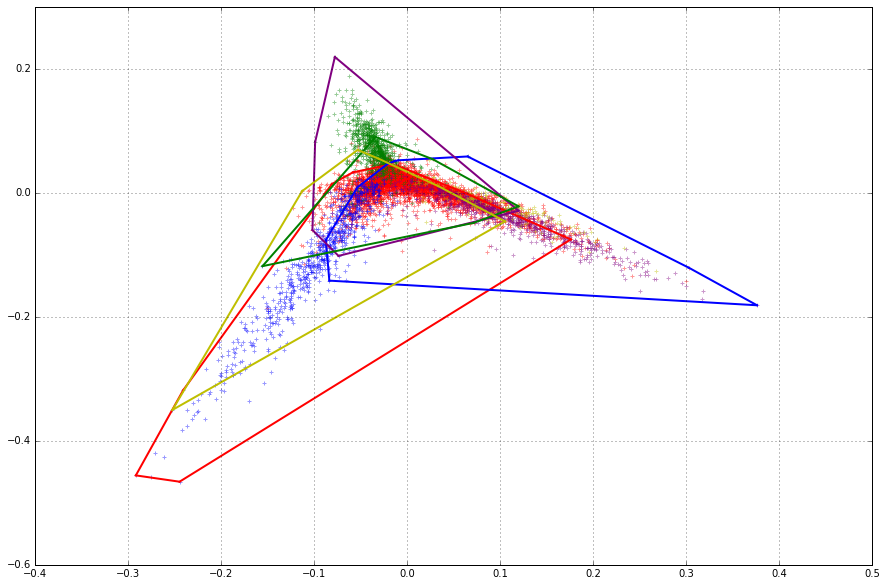

In [16]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 1, 1)

colors = ['r', 'b', 'purple', 'g', 'y']
for i in range(5):
    x_pred = X_tr[:, 0][agc.labels_ == i]
    y_pred = X_tr[:, 1][agc.labels_ == i]
    plt.scatter(x_pred, y_pred, c=colors[i], alpha=0.4, marker='+')
#     x_real = X_tr[:, 0][y == i]
#     y_real = X_tr[:, 1][y == i]
#     x_c = np.mean(x_real)
#     y_c = np.mean(y_real)
#     r = 0
#     for tmp_x, tmp_y in X_tr:
#         tmp_r = get_dist(tmp_x, tmp_y, x_c, y_c)
#         if tmp_r > r:
#             r = tmp_r
#     print r
#     c = plt.Circle((x_c, y_c), r, color=colors[i], fill=False)
#     ax.add_patch(c)
    xy = X_tr[y == i]
    hull = ConvexHull(xy)
    for simplex in hull.simplices:
        plt.plot(xy[simplex, 0], xy[simplex, 1], colors[i], linewidth=2.0)

plt.grid(True)